
## Task:
1. Try to quantize the full model, run on data, check the difference in the output wrt. the fp32 model.
2. Try to quantize the full model, run on data, check the difference in the output wrt. the fp16 model.
3. Try to quantize the full model, run on data, check the difference in the output wrt. the int8 model.
4. what matters is if you quantize a layer or the whole network, how does the inference runtime of the network change?
5. measuring the inference throughput (time per batch)? that would be the relevant metric, along with the error in the output compared to the fp32 version
6. run the inference on a bunch of real events from the dataset, and check the error introduced by quantization in the inference compared to fp32. and also measure the inference time
8. To check the error in the ouptu, do we need to use all of the quantized weights or a few of them?
9. What is the role of the .pkl file?


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import h5py

import tensorflow as tf
import tensorflow_datasets as tfds


2023-10-27 08:12:08.582366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 08:12:08.615761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 08:12:08.615785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 08:12:08.615839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 08:12:08.622573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 08:12:08.623191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

The given datasets are tensorflow datasets, which can be loaded as 
```python
import tensorflow as tf
import tensorflow_datasets as tfds

ds_builder = tfds.builder("clic_edm_qq_pf")
dss = ds_builder.as_data_source("test")

for elem in dss:
    print({"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]})
```
X is each event that you can feed to the model



In [8]:
 '../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/clic_edm_qq_pf-test.array_record-00000-of-00032'

'../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/clic_edm_qq_pf-test.array_record-00000-of-00032'

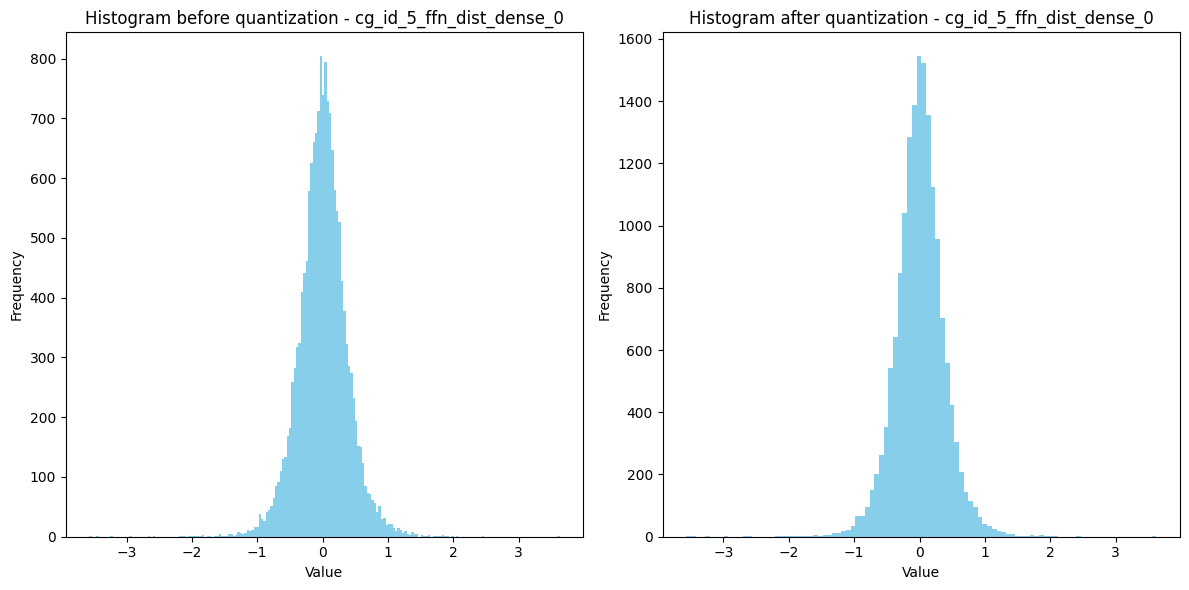

Output with Float 16 Quantization
Subgroup Name: cg_id_5_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 390.85714285714283x



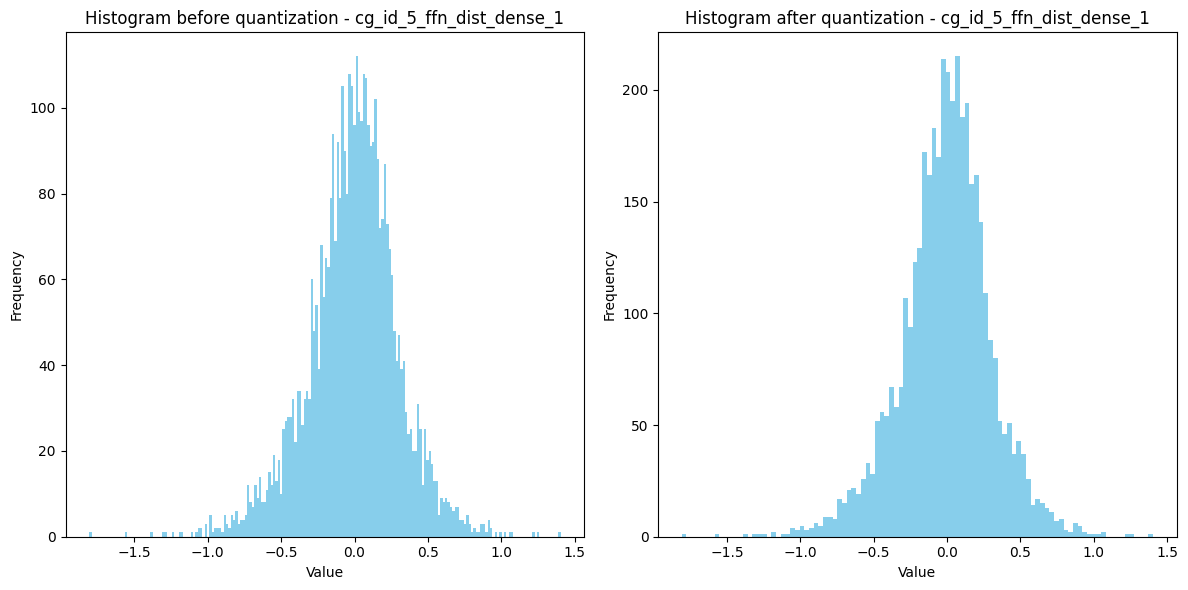

Output with Float 16 Quantization
Subgroup Name: cg_id_5_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



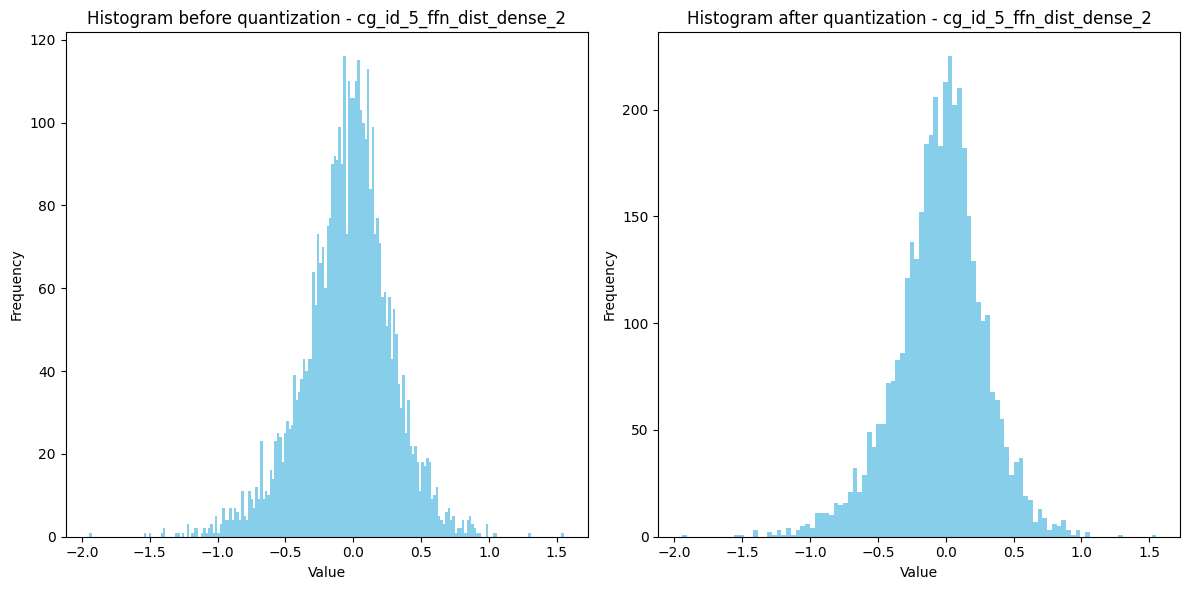

Output with Float 16 Quantization
Subgroup Name: cg_id_5_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



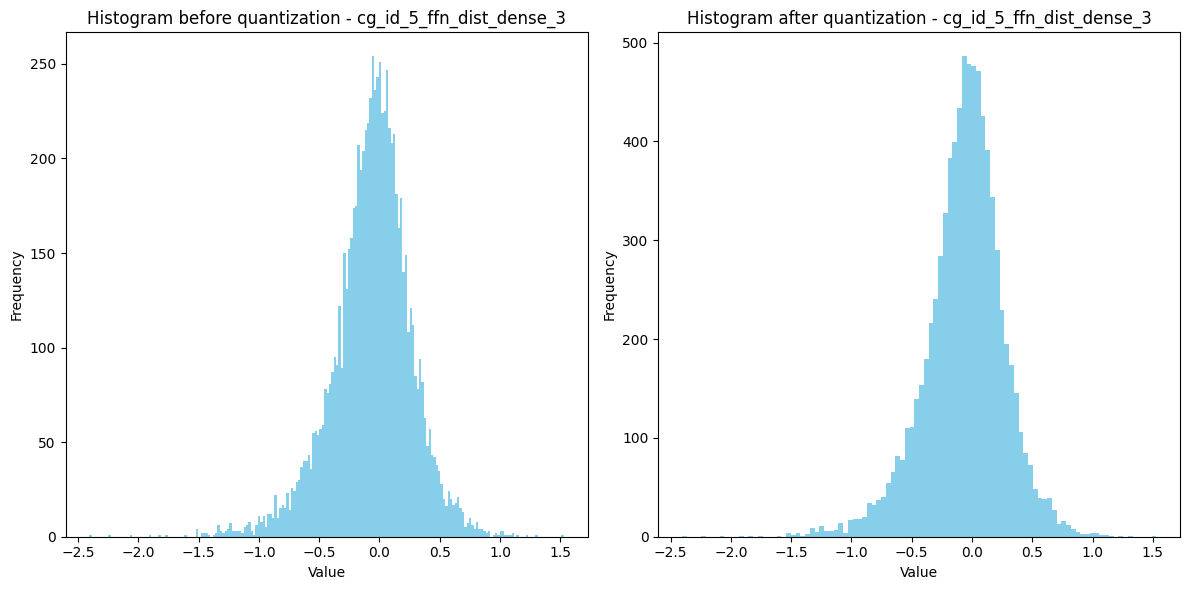

Output with Float 16 Quantization
Subgroup Name: cg_id_5_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 3.7142857142857144x
Reduction Factor for Kernel: 195.8095238095238x

Total Original Bias Size: 1728 bytes
Total Original Kernel Size: 131584 bytes
Total Quantized Bias Size: 672 bytes
Total Quantized Kernel Size: 672 bytes
Total Original Size: 133312 bytes
Total Quantized Size: 1344 bytes
Reduction Factor: 99.19047619047619x


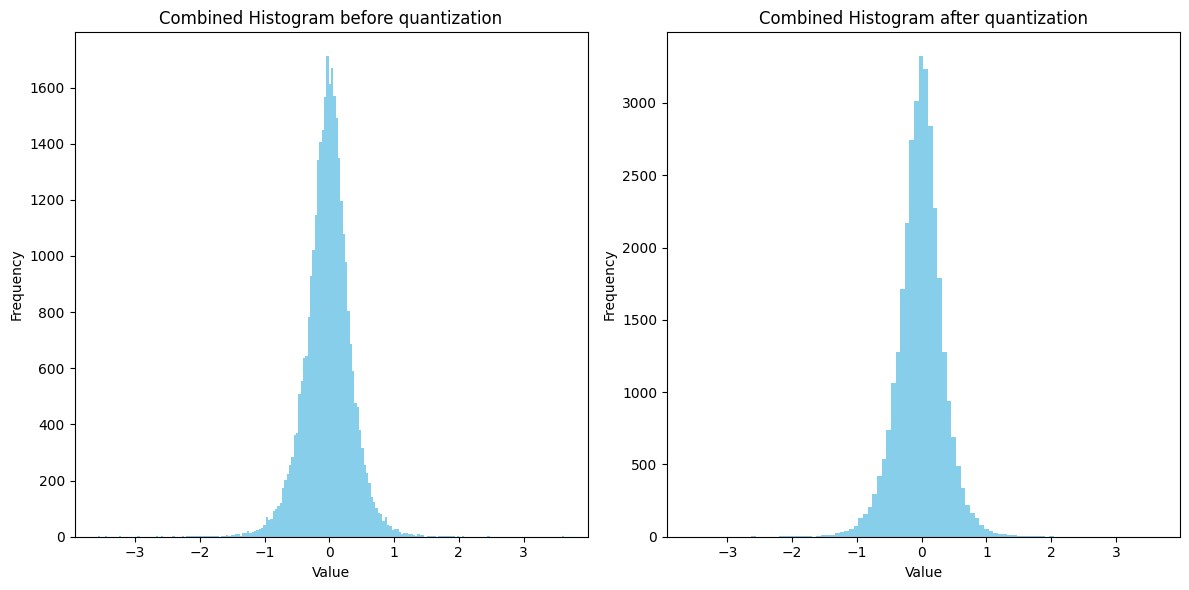

In [3]:
import h5py
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0

all_original_kernel_values = []
all_quantized_kernel_values = []

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_5 = file['cg_id_5']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_5_ffn_dist_dense_0', 
                      'cg_id_5_ffn_dist_dense_1', 
                      'cg_id_5_ffn_dist_dense_2', 
                      'cg_id_5_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_5[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = float16_quantization(bias)
        float16_kernel = float16_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        # Plot the histograms
        plt.figure(figsize=(12, 6))
        
        # Before quantization
        plt.subplot(1, 2, 1)
        plt.hist(kernel.flatten(), bins=200, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram before quantization - {subgroup_name}')
        
        # After quantization
        plt.subplot(1, 2, 2)
        float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel)
        float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
        plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram after quantization - {subgroup_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Store kernel values for final combined plot
        all_original_kernel_values.extend(kernel.flatten())
        all_quantized_kernel_values.extend(float16_kernel_array.flatten())
        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size

# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

# Plot the final combined histograms
plt.figure(figsize=(12, 6))

# Before quantization
plt.subplot(1, 2, 1)
plt.hist(all_original_kernel_values, bins=200, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram before quantization')

# After quantization
plt.subplot(1, 2, 2)
plt.hist(all_quantized_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram after quantization')

plt.tight_layout()
plt.show()


*Task:* \
**Run the inference on a bunch of real events from the dataset, and check the error introduced by quantization in the inference compared to fp32. and also measure the inference time**

1. **Load and Preprocess the Data:** \
Load the dataset and preprocess it for inference. If the dataset contains images, make sure to normalize them to the range [0, 1].

2. **Load the Model:** \
Load the model you want to evaluate. Ensure that the model is compatible with float16 weights. You may need to convert the model to use float16 if it's not already.

3. **Apply Float16 Quantization:** \
Apply float16 quantization to the weights of the model. This ensures that the weights are in float16 format before inference.

4. **Run Inference:** \
Use the model to make predictions on the dataset.

5. **Compare Results:** \
Compare the results from float16 quantization with the results from fp32 to see if there are any significant differences.

6. **Measure Inference Time:** \
Record the time taken to perform inference on the dataset using both float16 and fp32.





#### Reading Features name from `JSON file`

In [4]:
import json

# Load the JSON data
with open('../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/metadata.json', 'r') as file:
    data = json.load(file)

# Access the specific features
x_features_track = data['x_features_track']
x_features_cluster = data['x_features_cluster']
y_features = data['y_features']

# Now you can work with these features
# For example, print them out
print("x_features_track:", x_features_track)
print("x_features_cluster:", x_features_cluster)
print("y_features:", y_features)


x_features_track: ['elemtype', 'pt', 'eta', 'sin_phi', 'cos_phi', 'p', 'chi2', 'ndf', 'dEdx', 'dEdxError', 'radiusOfInnermostHit', 'tanLambda', 'D0', 'omega', 'Z0', 'time']
x_features_cluster: ['elemtype', 'et', 'eta', 'sin_phi', 'cos_phi', 'energy', 'position.x', 'position.y', 'position.z', 'iTheta', 'energy_ecal', 'energy_hcal', 'energy_other', 'num_hits', 'sigma_x', 'sigma_y', 'sigma_z']
y_features: ['PDG', 'charge', 'pt', 'eta', 'sin_phi', 'cos_phi', 'energy', 'jet_idx']


## Applying Quantization on the dataset


We are facing problem of applying the quantization on the dataset and  run the inference on a bunch of real events from the dataset, and check the error introduced by quantization in the inference compared to fp32. and also measure the inference time

In [5]:
import json
import tensorflow as tf


Features in my dataset

In [6]:
# Load the JSON data
with open('../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/metadata.json', 'r') as file:
    data = json.load(file)

x_features_track = data['x_features_track']
x_features_cluster = data['x_features_cluster']
y_features = data['y_features']

### Open the dataset files and see what it contains


In [7]:
import tensorflow as tf

# Define a function to parse each record
def parse_record(record):
    feature_description = {
        'x_features_track': tf.io.FixedLenFeature([num_features_track], tf.float32),
        'x_features_cluster': tf.io.FixedLenFeature([num_features_cluster], tf.float32),
        'y_features': tf.io.FixedLenFeature([num_features_y], tf.float32),
    }
    return tf.io.parse_single_example(record, feature_description)

# List of file paths
file_paths = [
    '../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/clic_edm_qq_pf-train.array_record-00037-of-00128',
    '../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/clic_edm_qq_pf-train.array_record-00038-of-00128',
    # Add paths for other files as needed
]

# Create a dataset from the TFRecord files
dataset = tf.data.TFRecordDataset(file_paths)

# Define the number of features for each type
num_features_track = len(data['x_features_track'])
num_features_cluster = len(data['x_features_cluster'])
num_features_y = len(data['y_features'])

# Map the parsing function to each record
parsed_dataset = dataset.map(parse_record)

# Now `parsed_dataset` contains the parsed records with the features as tensors
parsed_dataset

<_MapDataset element_spec={'x_features_cluster': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'x_features_track': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'y_features': TensorSpec(shape=(8,), dtype=tf.float32, name=None)}>

## Apply the Float 16 quantization

In [8]:
# Define a function for float16 quantization
def float16_quantization(features):
    return tf.dtypes.cast(features, tf.float16)

# Apply quantization to the parsed dataset
quantized_dataset = parsed_dataset.map(lambda x: {
    'x_features_track': float16_quantization(x['x_features_track']),
    'x_features_cluster': float16_quantization(x['x_features_cluster']),
    'y_features': float16_quantization(x['y_features'])
})


## Check the quantization output

In [10]:
# Iterate through the quantized dataset and print the quantized features
for features in quantized_dataset:
    print("Quantized x_features_track:")
    print(features['x_features_track'])
    
    print("Quantized x_features_cluster:")
    print(features['x_features_cluster'])
    
    print("Quantized y_features:")
    print(features['y_features'])


DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 0 (Is this even a TFRecord file?) [Op:IteratorGetNext] name: 

## Calculate the precision loss

In [6]:
import numpy as np

# Define a function to compute Mean Absolute Error (MAE)
def compute_mae(original, quantized):
    return np.mean(np.abs(original - quantized))

# Define a function to compute Mean Squared Error (MSE)
def compute_mse(original, quantized):
    return np.mean((original - quantized)**2)

# Assuming you have the original features and quantized features as numpy arrays
original_x_features_track = np.array(...)  # Replace with your original data
original_x_features_cluster = np.array(...)  # Replace with your original data
original_y_features = np.array(...)  # Replace with your original data

quantized_x_features_track = np.array(...)  # Replace with your quantized data
quantized_x_features_cluster = np.array(...)  # Replace with your quantized data
quantized_y_features = np.array(...)  # Replace with your quantized data

# Compute MAE and MSE for each feature
mae_x_features_track = compute_mae(original_x_features_track, quantized_x_features_track)
mse_x_features_track = compute_mse(original_x_features_track, quantized_x_features_track)

mae_x_features_cluster = compute_mae(original_x_features_cluster, quantized_x_features_cluster)
mse_x_features_cluster = compute_mse(original_x_features_cluster, quantized_x_features_cluster)

mae_y_features = compute_mae(original_y_features, quantized_y_features)
mse_y_features = compute_mse(original_y_features, quantized_y_features)

print(f"MAE for x_features_track: {mae_x_features_track}")
print(f"MSE for x_features_track: {mse_x_features_track}")
print(f"MAE for x_features_cluster: {mae_x_features_cluster}")
print(f"MSE for x_features_cluster: {mse_x_features_cluster}")
print(f"MAE for y_features: {mae_y_features}")
print(f"MSE for y_features: {mse_y_features}")


In [15]:
# Load the TFRecordDataset
dataset = tf.data.TFRecordDataset(['../../tensorflow_datasets/clic_edm_qq_pf/1.5.0/'])


In [16]:
# Apply the parsing function to decode the TFRecord entries
parsed_dataset = dataset.map(parse_function)



In [17]:
# Apply Float16 quantization (adjust this based on your specific requirements)
def float16_quantization(tensor):
    return tf.dtypes.cast(tensor, tf.float16)


In [18]:
# Apply quantization to specific features (adjust as needed)
quantized_dataset = parsed_dataset.map(lambda x: {'x_feature_1': float16_quantization(x['x_feature_1']),
                                                  'x_feature_2': float16_quantization(x['x_feature_2'])})


In [19]:
# Optional: Save the quantized dataset back to TFRecord format
def serialize_example(feature_1, feature_2):
    feature = {
        'x_feature_1': tf.train.Feature(float_list=tf.train.FloatList(value=feature_1.numpy())),
        'x_feature_2': tf.train.Feature(float_list=tf.train.FloatList(value=feature_2.numpy())),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


In [20]:
output_file = 'quantized_dataset.tfrecord'
writer = tf.io.TFRecordWriter(output_file)


In [21]:
for example in quantized_dataset:
    feature_1 = example['x_feature_1']
    feature_2 = example['x_feature_2']
    serialized_example = serialize_example(feature_1, feature_2)
    writer.write(serialized_example)

writer.close()

FailedPreconditionError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ../../tensorflow_datasets/clic_edm_qq_pf/1.5.0; Is a directory [Op:IteratorGetNext] name: 